# Curve Detection

This builds upon the ideas of our original questing, except in addition to a horizontal layer/associated quest and a vertical layer/associated quest, we are introducing a curve/contour layer/associated quest.

The question is, how can we get just curves? Contour and canny detection algorithms appear to give just a variation of the original image in most cases.

Can we use some sort of interesting masking technique?

Maybe hough transforms?

## Imports

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, vertical_kernel, horizontal_kernel

## Load Data

In [5]:
# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

# Exploration below

## Attempt 1: Curve Detection Via Contours/Masking

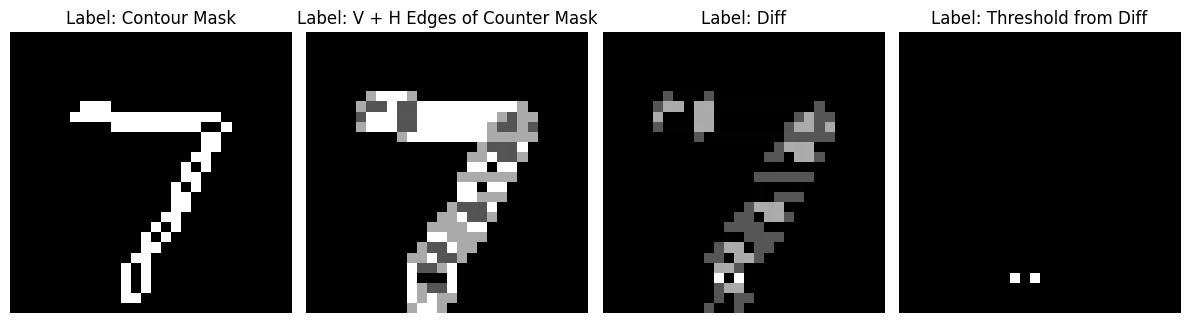

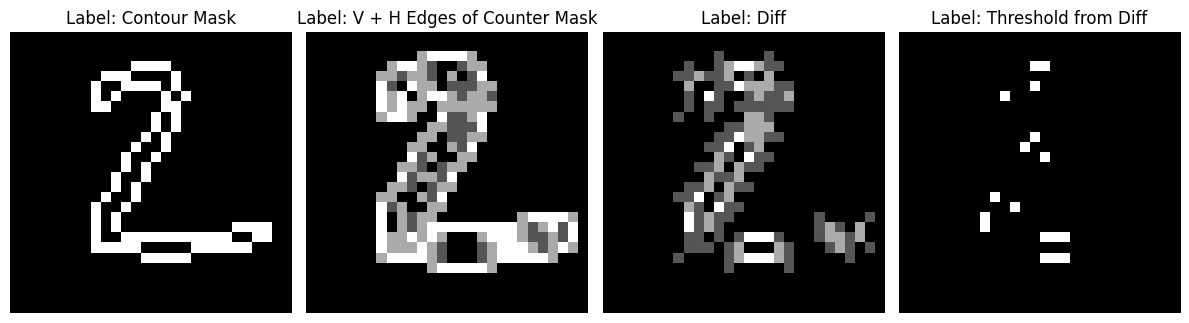

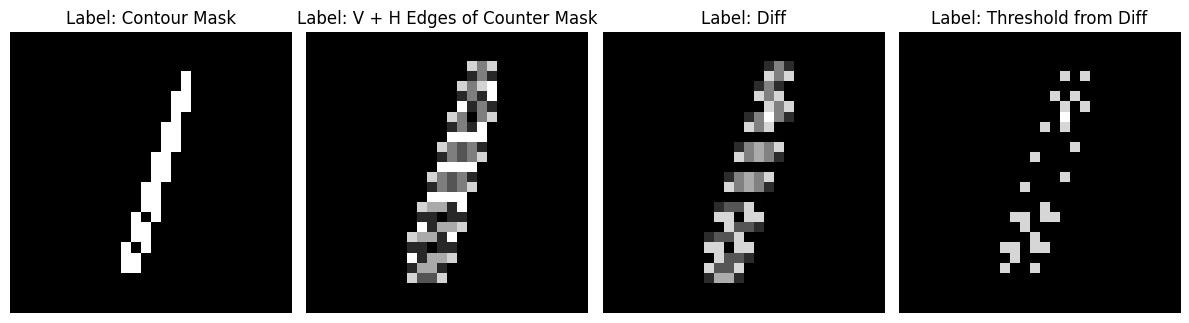

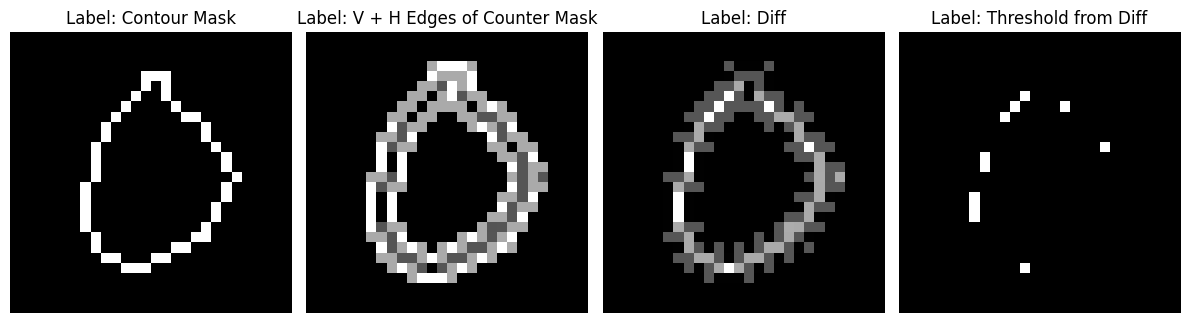

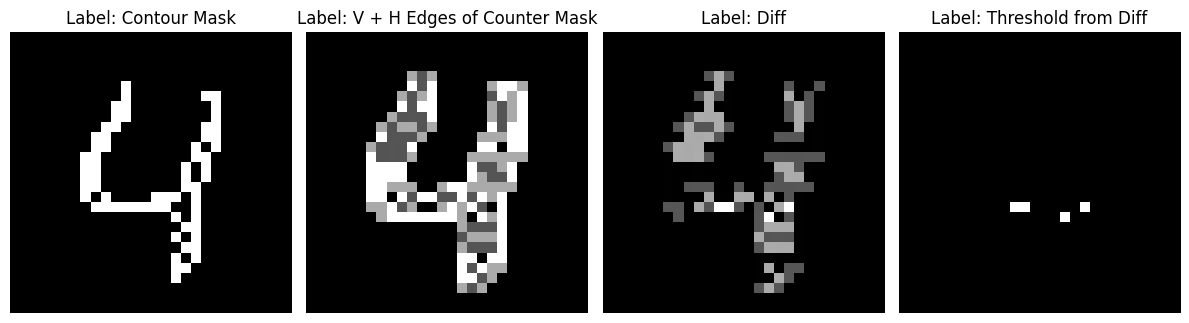

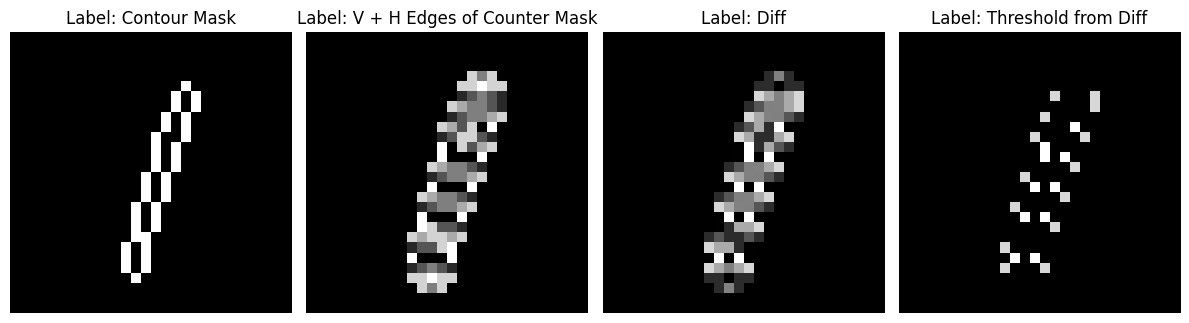

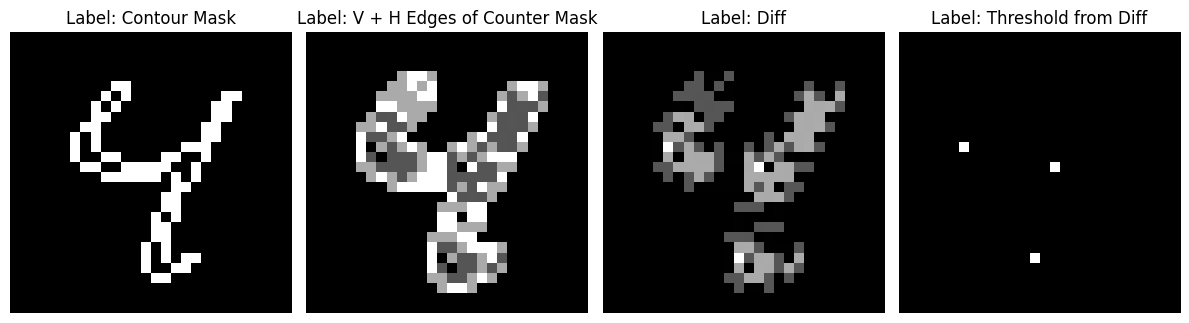

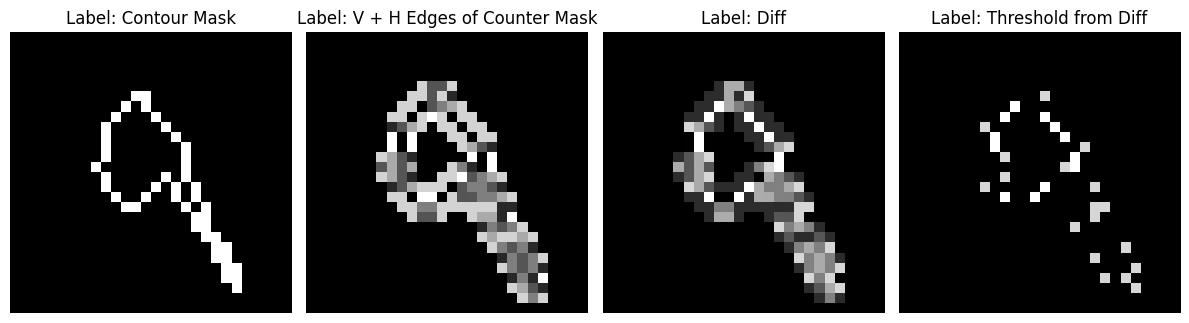

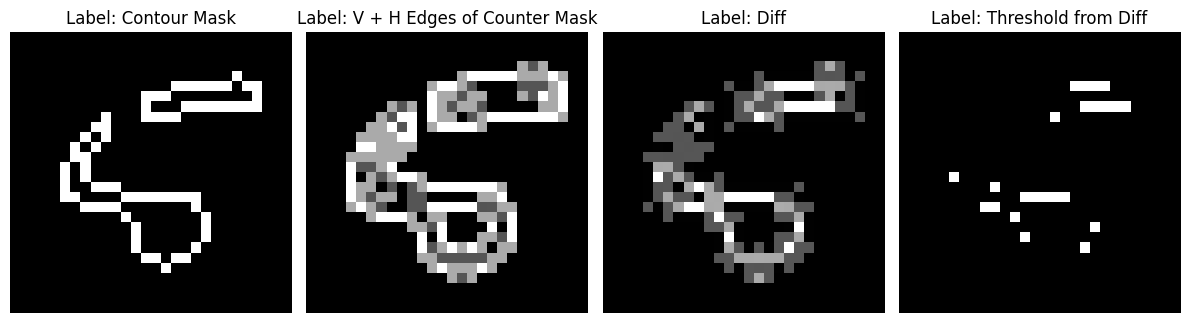

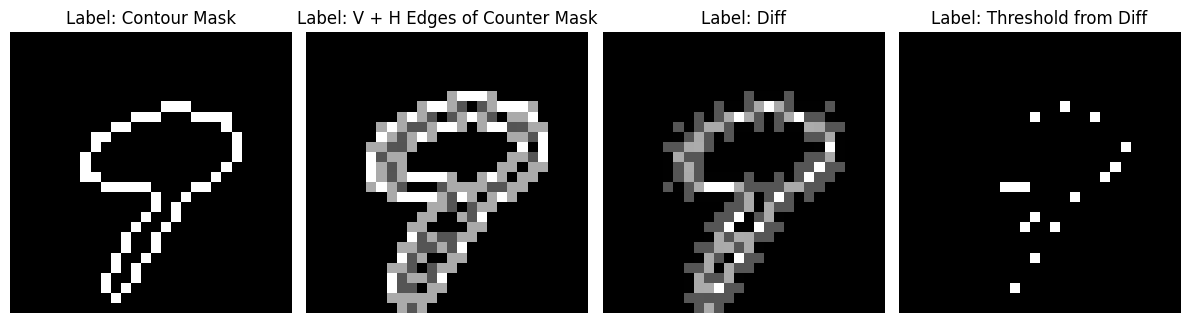

In [6]:
for idx in range(0, 10):
    # selecting image to use
    img = test_images[idx]
    label = test_labels[idx]
    
    # grabbing contours
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contour_mask = np.zeros_like(thresh)
    cv2.drawContours(contour_mask, contours, -1, 255, 1)
    
    # grabbing it's edges
    h_edge = generate_intermediate_edge_labels([contour_mask], horizontal_kernel)[0].reshape(28, 28)
    v_edge = generate_intermediate_edge_labels([contour_mask], vertical_kernel)[0].reshape(28, 28)
    
    # combinations to try and get just curves
    total = v_edge + h_edge
    diff = np.abs(contour_mask - total)
    
    # thresholding
    threshold = 200
    thres_img = np.where(diff < threshold, 0, diff)
    
    # visualize images
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    
    visualize_image(contour_mask, "Contour Mask", ax=axes[0])
    visualize_image(total, "V + H Edges of Counter Mask", ax=axes[1])
    visualize_image(diff, "Diff", ax=axes[2])
    visualize_image(thres_img, "Threshold from Diff", ax=axes[3])
    
    plt.tight_layout()
    plt.show()

## Attempt 2: Hough Transforms

In [7]:
from skimage import feature, color
from skimage.transform import hough_circle, hough_circle_peaks

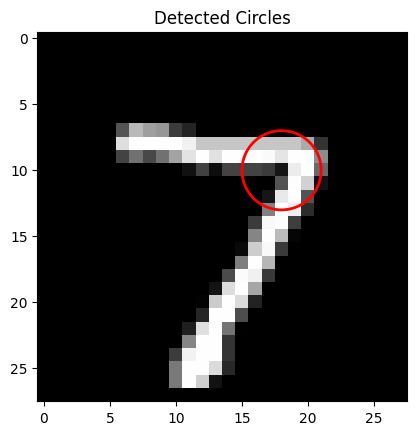

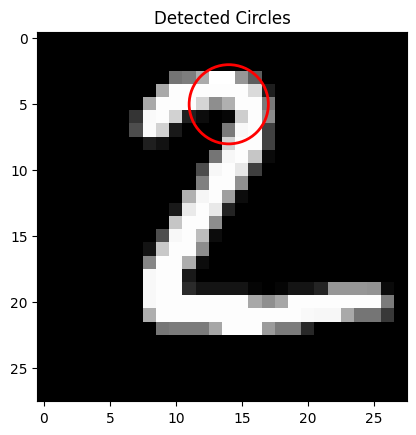

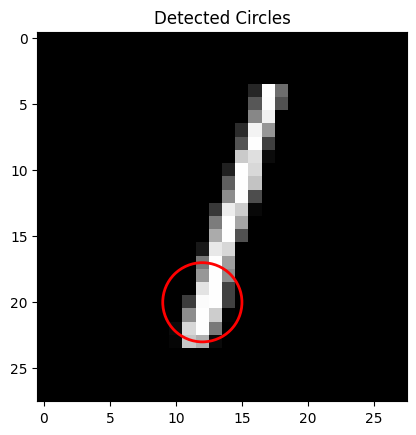

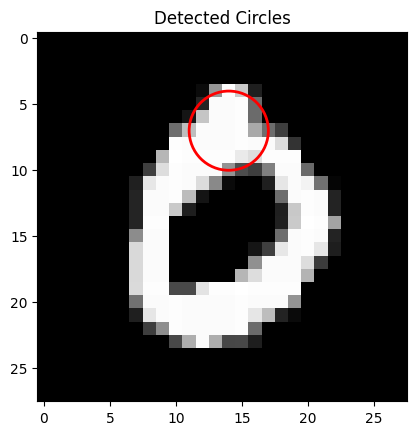

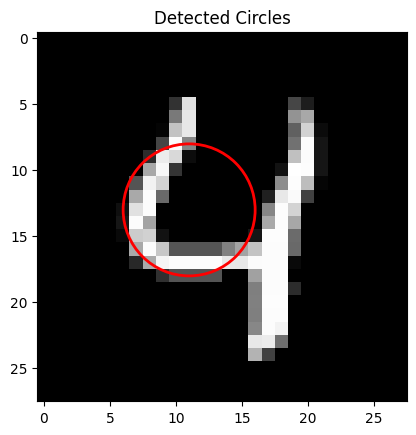

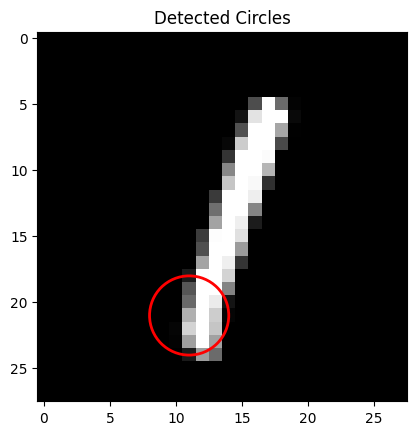

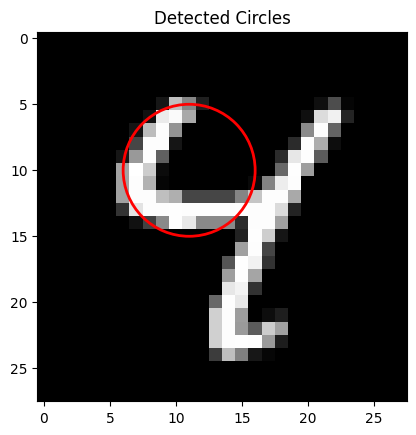

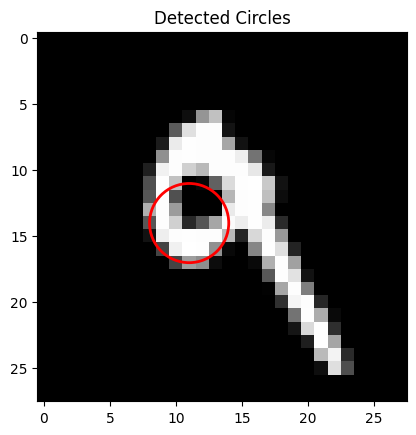

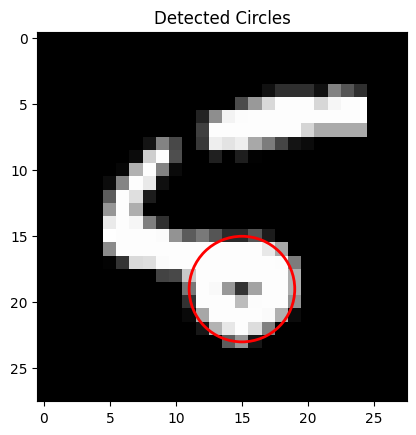

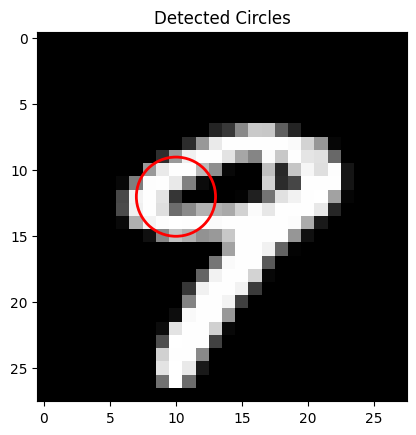

In [8]:
for idx in range(0, 10):
    img = test_images[idx]
    edges = feature.canny(img, sigma=1, low_threshold=0.1, high_threshold=0.3)
    
    # 2) Choose radii (range of possible circle radii).
    #    For a 28x28 image, typical circle might have radius from 3 to ~12:
    hough_radii = np.arange(3, 13, 1)
    
    # 3) Perform the Hough Circle transform:
    hough_res = hough_circle(edges, hough_radii)
    
    # 4) Identify the most prominent circles (peaks in the accumulator):
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               min_xdistance=5, min_ydistance=5)
    
    # 5) Optionally draw them on the image:
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    for center_x, center_y, radius in zip(cx, cy, radii):
        # Create a circle patch for visualization:
        circle = plt.Circle((center_x, center_y), radius, color=(1,0,0), fill=False, linewidth=2)
        ax.add_patch(circle)
        break
    
    plt.title("Detected Circles")
    plt.show()

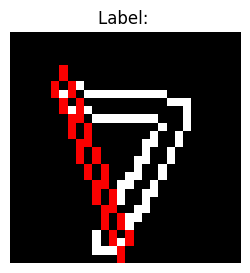

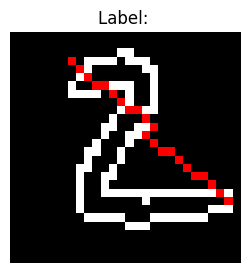

IndexError: index -1 is out of bounds for axis 0 with size 0

In [9]:
import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

for idx in range(0, 10):
    img = test_images[idx]
    edges = feature.canny(img, sigma=1)
    
    result = hough_ellipse(edges, accuracy=20, threshold=50, min_size=4, max_size=28)
    result.sort(order='accumulator')
    
    best = list(result[-1])
    yc, xc, a, b = (int(round(x)) for x in best[1:5])
    orientation = best[5]
    
    cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
    edges = color.gray2rgb(img_as_ubyte(edges))
    
    valid_mask = (
        (cy >= 0) & (cy < edges.shape[0]) &
        (cx >= 0) & (cx < edges.shape[1])
    )
    
    # Use the mask to index only valid points
    edges[cy[valid_mask], cx[valid_mask]] = (250, 0, 0)
    
    visualize_image(edges, "")

## Our Convolutions

In [10]:
curve_kernel = np.array([
    [  0,  0,-.5, -1,  0],
    [  0,-.5, -1,  0,  1],
    [-.5, -1,  0,  1, .5],
    [ -1,  0,  1, .5,  0],
    [ 0,  1, .5,  0,  0]
])

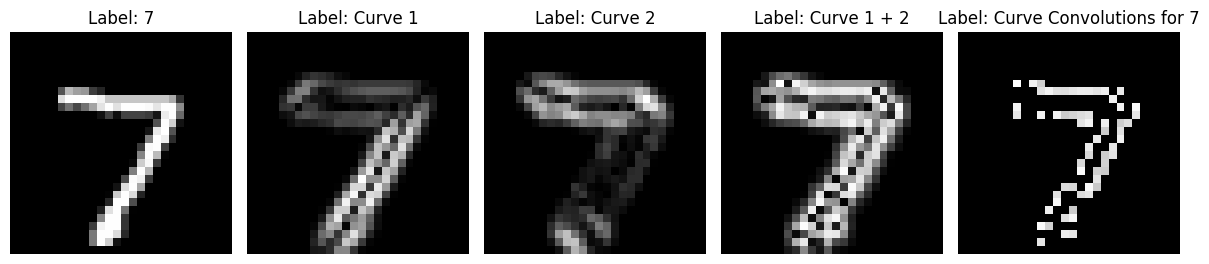

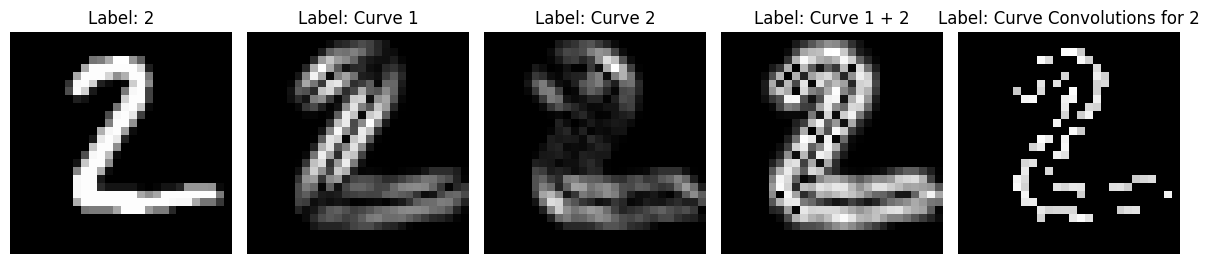

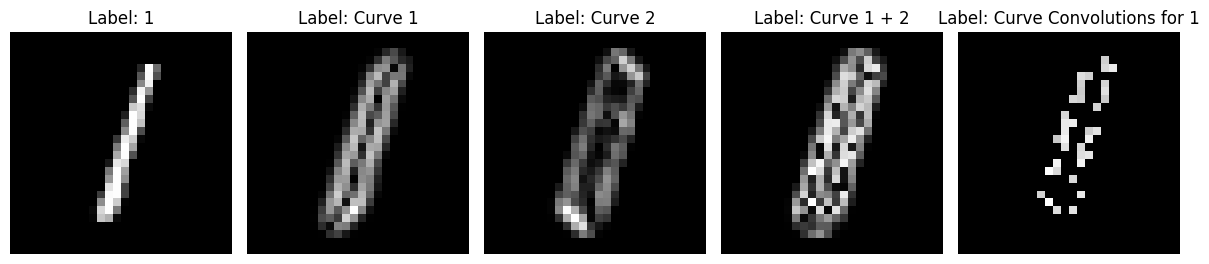

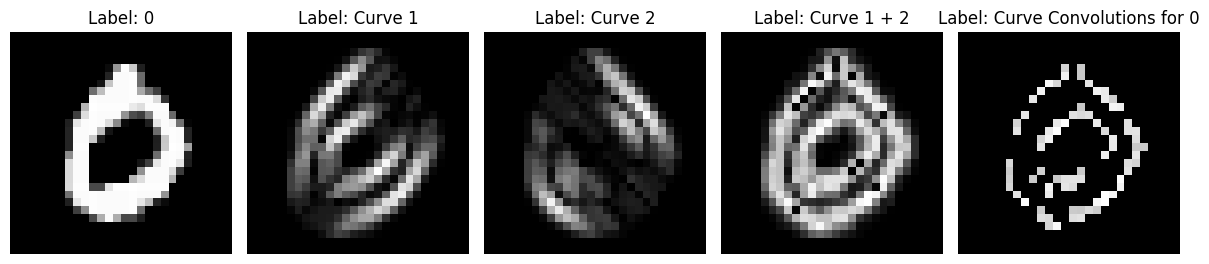

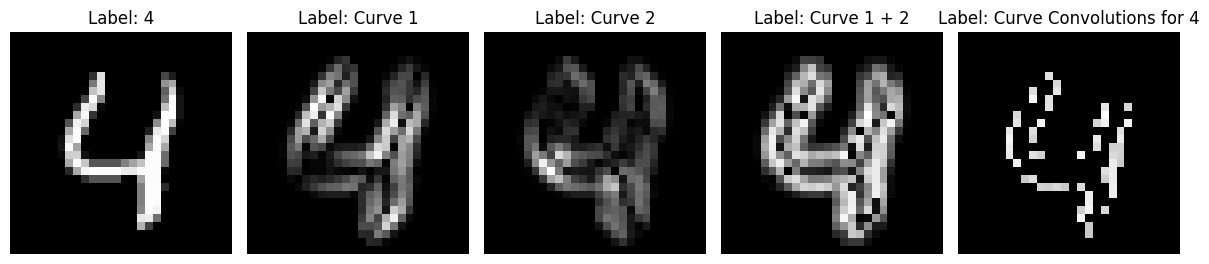

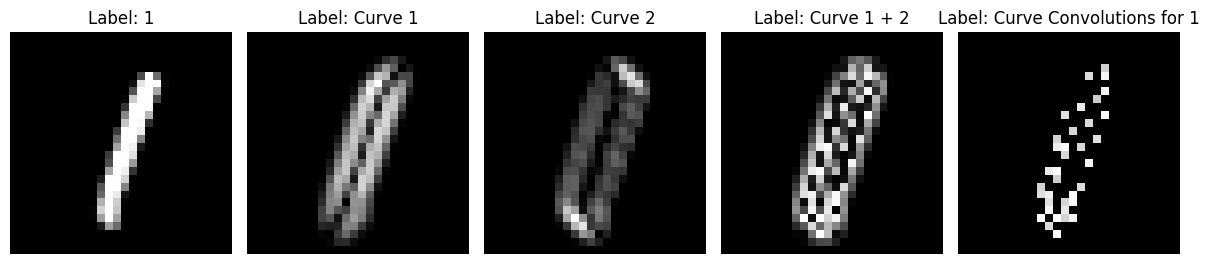

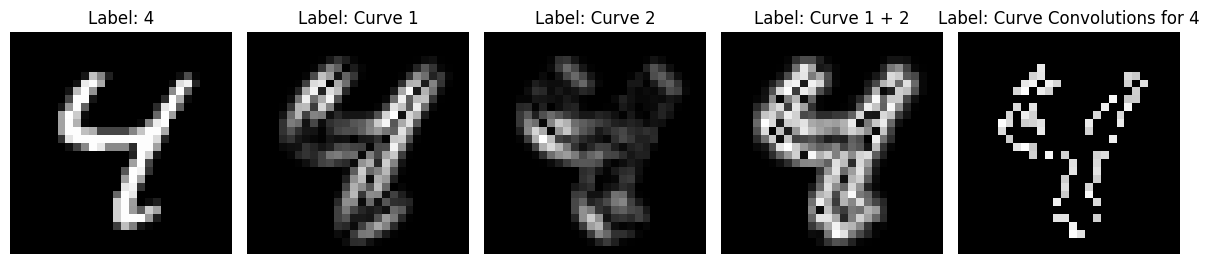

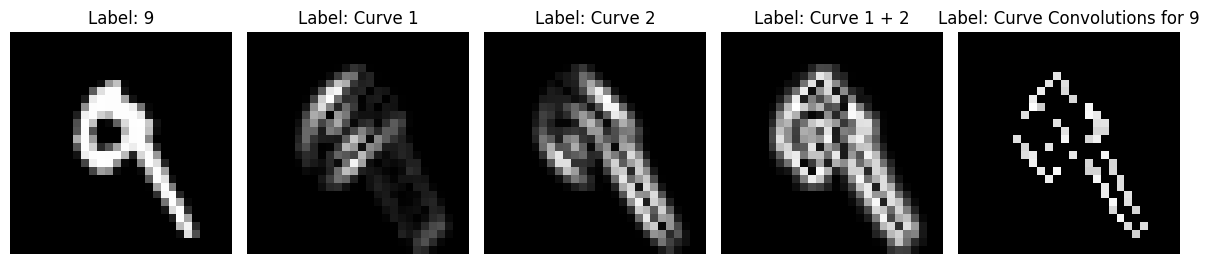

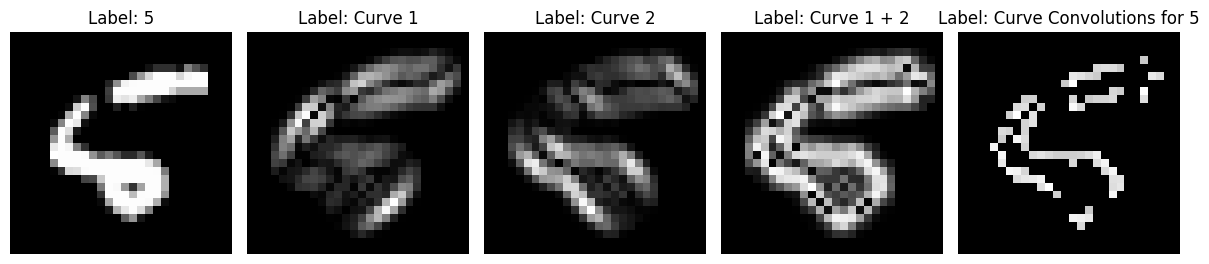

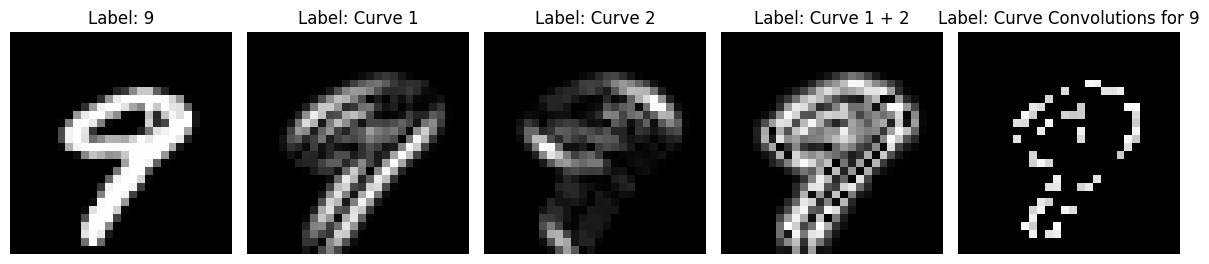

In [11]:
from scipy.signal import convolve2d

for idx in range(0, 10):
    img = test_images[idx]
    curve_1 = get_edges(curve_kernel, img)
    
    rot1 = np.rot90(curve_kernel)
    curve_2 = get_edges(rot1, img)
    
    curves = (curve_1 + curve_2) / 2

    threshold = 100
    thres_curve_img = np.where(curves < threshold, 0, curves)
    

    # visualize images
    fig, axes = plt.subplots(1, 5, figsize=(12, 5))
    
    visualize_image(img, test_labels[idx], ax=axes[0])
    visualize_image(curve_1, "Curve 1", ax=axes[1])
    visualize_image(curve_2, "Curve 2", ax=axes[2])
    visualize_image(curve_1 + curve_2, "Curve 1 + 2", ax=axes[3])
    visualize_image(thres_curve_img, f"Curve Convolutions for {test_labels[idx]}", ax=axes[4])
    
    plt.tight_layout()
    plt.show()

In [12]:
from scipy.ndimage import rotate

generated_curves = dict()
for theta in range(0, 180 + 1, 10):
    rotated_kernel = rotate(curve_kernel, theta)
    for idx in range(0, 10):
        img = test_images[idx]
        curve = get_edges(rotated_kernel, img)
        if idx in generated_curves:
            generated_curves[idx].append(curve)
        else:
            generated_curves[idx] = [curve]

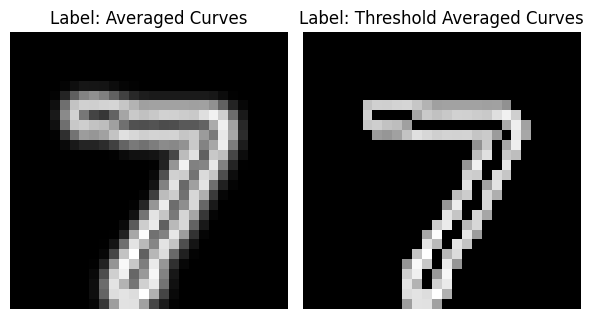

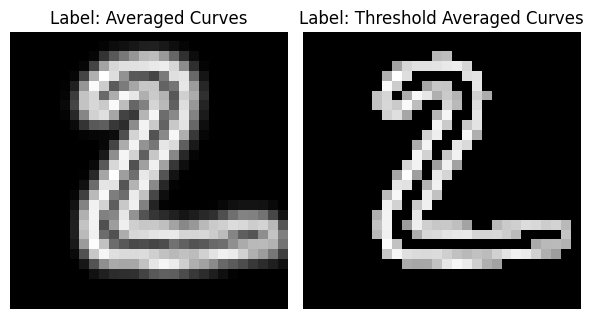

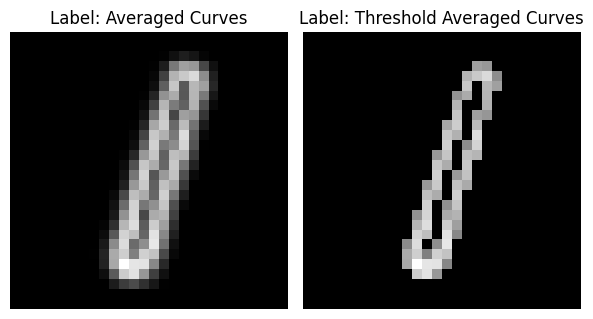

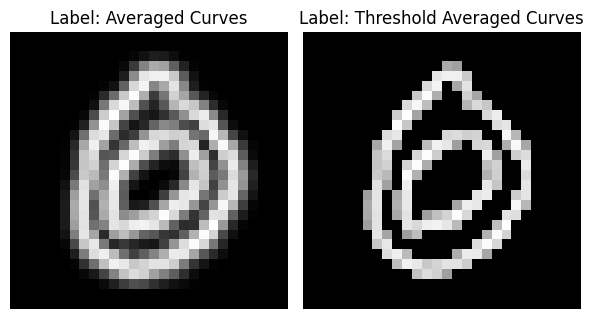

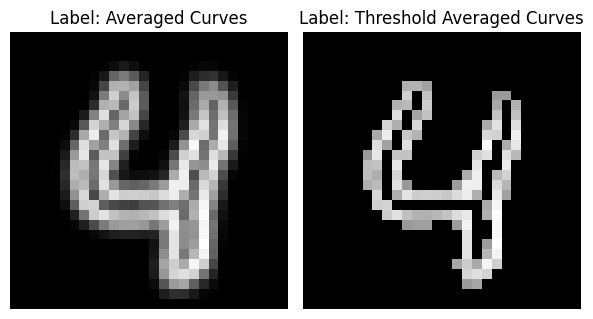

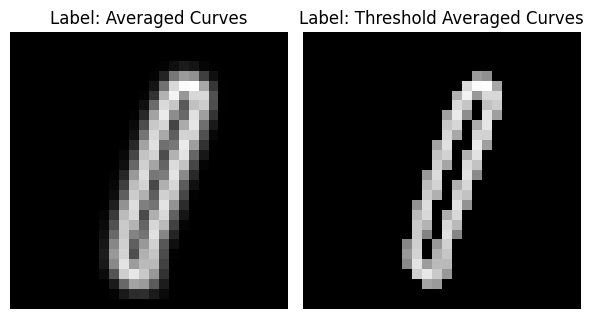

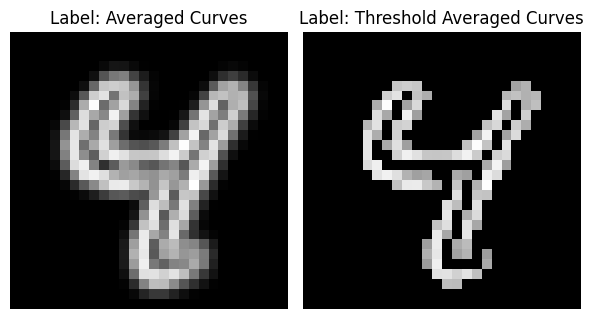

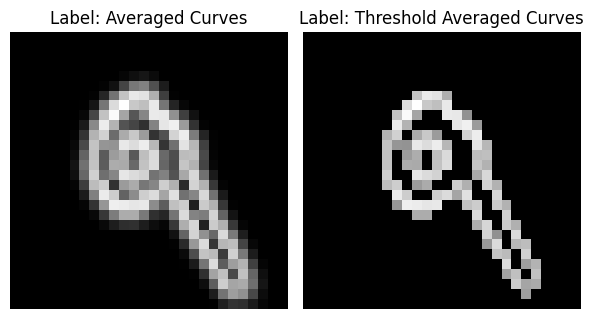

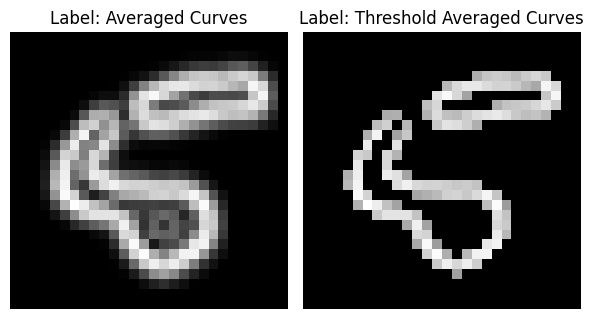

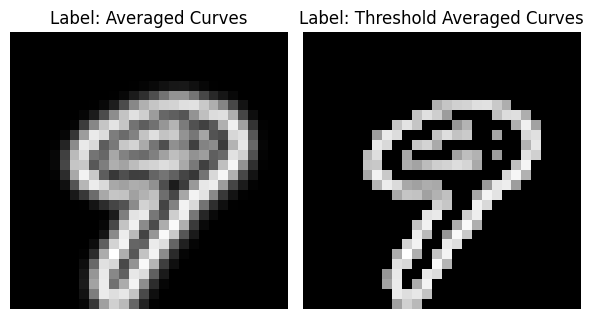

In [13]:
for key in generated_curves.keys():
    total = np.zeros((28, 28))
    for c in generated_curves[key]:
        total += c

    avg_curves = total / 19

    threshold = 80
    thres_curve = np.where(avg_curves < threshold, 0, avg_curves)

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    
    visualize_image(avg_curves, "Averaged Curves", ax=axes[0])
    visualize_image(thres_curve, "Threshold Averaged Curves", ax=axes[1])
 
    plt.tight_layout()
    plt.show()

This what we'll be going with. It's still not exactly what I had in mind, but I do think it's the best curve representation of the digits thus far.